In [1]:
# clean up outputs from warnings
import warnings
import numpy as np
import pandas as pd
import networkx as nx
warnings.filterwarnings("ignore")

In [ ]:
import scraper

category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph, infos  = await scraper.scrape_wiki(category_titles)
nx.write_graphml(page_graph, "wikigraph.graphml")

In [2]:
graph = nx.read_graphml("wikigraph.graphml")
# remove bots
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]
graph.remove_nodes_from(bot_names)


## Basic statistics

In [3]:
def largest_weakly_connected_c(graph):
     # extract largest weakly connected component
    connected_subgraphs = [graph.subgraph(c).copy() for c in nx.weakly_connected_components(graph)]
    max_conn_subgraph_index = np.argmax([len(graph) for graph in connected_subgraphs])
    return connected_subgraphs[max_conn_subgraph_index]

def largest_connected_c(graph):
     # extract largest connected component
    connected_subgraphs = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
    max_conn_subgraph_index = np.argmax([len(graph) for graph in connected_subgraphs])
    return connected_subgraphs[max_conn_subgraph_index]

def largest_strongly_connected_c(graph):
     # extract largest connected component
    subgraphs = [graph.subgraph(c).copy() for c in nx.strongly_connected_components(graph)]
    max_subgraph_index = np.argmax([len(graph) for graph in subgraphs])
    return subgraphs[max_subgraph_index]

def top_n_by_degree(degree_dict, n):
    stat_view = pd.DataFrame(degree_dict, columns=["Node", "Degree"]).set_index("Node")
    return stat_view.sort_values(["Degree"], ascending=False).head(n)

def basic_stats_undirected(graph, top_n):
    G_biggest_comp = largest_connected_c(graph)
    degree_stats = top_n_by_degree(G_biggest_comp.degree, top_n)
    return G_biggest_comp, degree_stats
    
def basic_stats_directed(graph, top_n):
    G_biggest_comp = largest_weakly_connected_c(graph)
    # Create degree statistics
    degree_stats = top_n_by_degree(G_biggest_comp.degree, top_n)
    in_degree_stats = top_n_by_degree(G_biggest_comp.in_degree, top_n)
    out_degree_stats = top_n_by_degree(G_biggest_comp.out_degree, top_n)

    stats = {"degree": degree_stats, "in_degree": in_degree_stats, "out_degree": out_degree_stats}
    return G_biggest_comp, stats

In [4]:
def create_grouping(graph, data_key):
    nodes_with_grouping = dict(graph.nodes(data=data_key))
    classes = set(nodes_with_grouping.values())
    grouping =  {}
    for type in classes:
        grouping[type] = list(filter(lambda key: nodes_with_grouping[key] == type, nodes_with_grouping))
    return grouping

In [5]:
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps

def fpl(x, a):
    return x ** (-a)

def render_degree_distributions(biggest_comp, colors, isDirected = True):
    count_nodes = biggest_comp.number_of_nodes()
    count_edges = biggest_comp.number_of_edges()

    # Random Graph
    avg_degree = np.fromiter(dict(biggest_comp.degree).values(), dtype=int).mean()
    er_graph = nx.erdos_renyi_graph(count_nodes, avg_degree/(count_nodes - 1))
    er_degrees = np.fromiter(dict(er_graph.degree).values(), dtype=int)
    hist_er = np.histogram(er_degrees, bins=np.sort(np.unique(er_degrees)))

    max_degree = max(dict(biggest_comp.degree).values())
    range_x = range(1, max_degree + 1)

    if isDirected:
        # Degree multiplicities
        in_degrees = np.fromiter(dict(biggest_comp.in_degree()).values(), dtype=int)
        hist_in = np.histogram(in_degrees, bins=np.sort(np.unique(in_degrees)))

        out_degrees = np.fromiter(dict(biggest_comp.out_degree()).values(), dtype=int)
        hist_out = np.histogram(out_degrees, bins=np.sort(np.unique(out_degrees)))
        
        max_multiplicity = max([max(hist_in[0]), max(hist_out[0])])

        # Exponents
        fit_in = powerlaw.Fit(hist_in[0], verbose=False)
        fit_out = powerlaw.Fit(hist_out[0], verbose=False)

        in_degrees_counts = pd.Series(dict(biggest_comp.in_degree()).values()).value_counts()
        out_degrees_counts = pd.Series(dict(biggest_comp.out_degree()).values()).value_counts()

        # Exponents
        fit_in = powerlaw.Fit(in_degrees_counts.sort_index().values, verbose=False)
        fit_out = powerlaw.Fit(out_degrees_counts.sort_index().values, verbose=False)

        exp_in = fit_in.alpha
        exp_out = fit_out.alpha

        print("Exponents:")
        print("In-degrees: " + str(exp_in) + " sigma: " + str(fit_in.sigma))
        print("Out-degrees: " + str(exp_out) + " sigma: " + str(fit_out.sigma))

        rows = 3
        data_dicts = [hist_in, hist_out, hist_er]
        dists = [fpl(range_x, exp_in), fpl(range_x, exp_out), sps.poisson.pmf(range_x, (count_edges/count_nodes))]
        titles = ["Multiplicity of In-degrees", "Multiplicity of Out-degrees", "Multiplicity of ER degrees"]
    else:
        degrees = np.fromiter(dict(biggest_comp.degree).values(), dtype=int)
        hist = np.histogram(degrees, bins=np.sort(np.unique(degrees)))

        max_multiplicity = max(hist[0])

        # Exponent
        fit_exp = powerlaw.Fit(hist[0], verbose=False)
        exp = fit_exp.alpha

        print("Exponents:")
        print("Degrees: " + str(exp) + " sigma: " + str(fit_exp.sigma))
        rows = 2
        data_dicts = [hist, hist_er]
        dists = [fpl(range_x, exp), sps.poisson.pmf(range_x, (count_edges/count_nodes))]
        titles = ["Multiplicity of Degrees", "Multiplicity of ER degrees"]
    # Plots
    fig, axs = plt.subplots(rows, 2, figsize=(12, 6))

    for y, (hist, dist, title, color) in enumerate(zip(data_dicts, dists, titles, colors)):
        counts, bins = hist
        widths = bins[1:] - bins[:-1]
        axs[y,0].bar(bins[:-1], counts, width=widths, label="Data", color=color)
        axs[y,0].plot(range_x, dist * count_nodes, "k-", lw=1, alpha=.75, label="Power Law fit")
        axs[y,0].set_title(title)

        axs[y,1].scatter(bins[:-1], counts, s=5, label="Data", color=color)
        axs[y,1].plot(range_x, dist * count_nodes, "k-", lw=1, alpha=.75, label="Power Law fit")
        axs[y,1].set_yscale("log")
        axs[y,1].set_xscale("log")
        axs[y,1].set_title(f"{title} [log-log]")

        for x in range(2):
            axs[y,x].set_xlim(x, max_degree)
            axs[y,x].set_ylim(x, max_multiplicity)
            axs[y,x].legend()

    for ax in axs.flat:
        ax.set(xlabel="Degree", ylabel="Multiplicity")

    fig.tight_layout()
    return fig, axs

In [6]:
type_grouping = create_grouping(graph, "page_class")

print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

graph_u = graph.to_undirected()
graph_s_comps = list(nx.strongly_connected_components(graph)) 
graph_w_comps = list(nx.weakly_connected_components(graph))
print(f"Number of strongly connected components: {len(graph_s_comps)}")
print(f"Number of weakly connected components: {len(graph_w_comps)}")
print(f"Average clustering coefficient: {nx.average_clustering(graph)}")

graph_largest_w, stats  = basic_stats_directed(graph, 10)
print(f"Number of nodes in largest weakly connected component: {graph_largest_w.number_of_nodes()}")
print(f"Number of edges in largest weakly connected component: {graph_largest_w.number_of_edges()}")

print("Top 5 nodes by overall degree")
stats["degree"]

Number of nodes: 80580
Number of edges: 176368
Number of strongly connected components: 79666
Number of weakly connected components: 1
Average clustering coefficient: 0.04063680702604195
Number of nodes in largest weakly connected component: 80580
Number of edges in largest weakly connected component: 176368
Top 5 nodes by overall degree


,Degree
Node,
United States,2458
Jesus,1942
India,1835
Climate change,1800
Israel,1696
Adolf Hitler,1592
World War II,1507
Muhammad,1464
Michael Jackson,1441


Exponents:
In-degrees: 3.82434359779719 sigma: 0.36769821723287816
Out-degrees: 1.4649090206801614 sigma: 0.04847011601848616


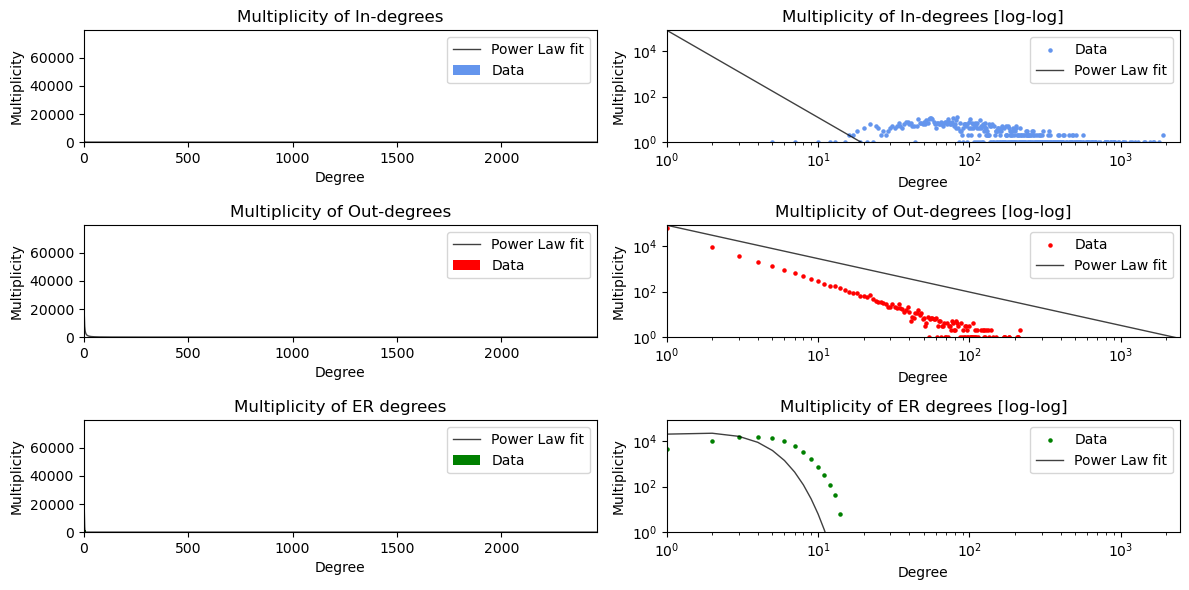

In [7]:
colors = ["cornflowerblue", "red", "green"]
render_degree_distributions(graph_largest_w, colors)
plt.show()

In [8]:
print("Top 5 nodes by in degree")
stats["in_degree"]

Top 5 nodes by in degree


,Degree
Node,
United States,2276
Jesus,1903
Climate change,1777
India,1652
Israel,1636
Adolf Hitler,1551
Michael Jackson,1436
Muhammad,1416
World War II,1297


In [9]:
print("Top 5 nodes by out degree")
stats["out_degree"]

Top 5 nodes by out degree


,Degree
Node,
User:ScottishFinnishRadish,235
User:Arjayay,215
World War II,210
Latin,209
User:Cannolis,207
India,183
United States,182
Aristotle,171
China,169


## Community analysis

Community analysis with the louvain algorithm on the edits and editors graph.

In [10]:
G_undirected = graph.to_undirected()
G_undirected.remove_nodes_from([node for node in G_undirected.nodes if G_undirected.degree(node) < 1])

louvain_partition = nx.community.louvain_communities(G_undirected)

print( "number of communities found: ", len(louvain_partition))
print("modularity of louvain partitions: ", nx.community.modularity(G_undirected, louvain_partition))

number of communities found:  38
modularity of louvain partitions:  0.5172799720699137


Size of each community printed:  [164, 243, 262, 312, 453, 544, 797, 806, 855, 952, 968, 1032, 1143, 1152, 1298, 1351, 1520, 1608, 1779, 2011, 2059, 2063, 2167, 2391, 2797, 2811, 2961, 3434, 3443, 3455, 3564, 3797, 3854, 3894, 4011, 4266, 4434, 5929]


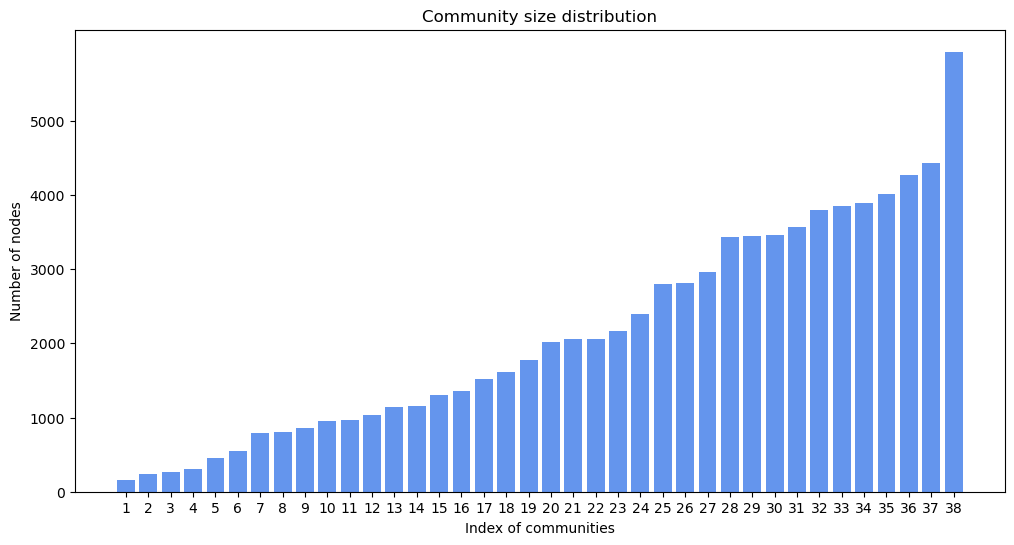

In [11]:
import matplotlib.pyplot as plt

def community_size_dist(partition):
    graph_communities = sorted([len(comm) for comm in partition])
    print("Size of each community printed: ", graph_communities)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(
        [x for x in range(1,len(partition)+1)], 
        graph_communities,
        color="cornflowerblue"
    )
    ax.set_title(label="Community size distribution")
    ax.set_xlabel(xlabel="Index of communities")
    ax.set_ylabel(ylabel="Number of nodes")
    ax.set_xticks([x for x in range (1,len(partition)+1)])
    ax.set_yticks([i for i in range (0, graph_communities[-1], 1000)])

community_size_dist(louvain_partition)
plt.show()


Testing the type partition's modularity. Unsurprisingly this is not a good partition.

In [12]:
type_partition_modularity = nx.community.modularity(G_undirected, list(type_grouping.values()))
print("Type partition modularity:", type_partition_modularity)

Type partition modularity: -0.41413487589468045


## Article pages subgraph

In [13]:
articles_graph = graph.subgraph(type_grouping["article"])
print(f"Number of nodes: {articles_graph.number_of_nodes()}")
print(f"Number of edges: {articles_graph.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(articles_graph)}")

articles_s_comps = list(nx.strongly_connected_components(graph)) 
articles_w_comps = list(nx.weakly_connected_components(graph))
print(f"Number of strongly connected components: {len(articles_s_comps)}")
print(f"Number of weakly connected components: {len(articles_w_comps)}")

articles_largest_w, degree_stats_articles = basic_stats_directed(articles_graph, 5)
print(f"Average clustering coefficient in largest component: {nx.average_clustering(articles_largest_w)}")
articles_largest_s_c = largest_strongly_connected_c(articles_graph)
print(f"Average shortest path length in largest strongly connected component: {nx.average_shortest_path_length(articles_largest_s_c)}")

print("Top 5 nodes by overall degree")
degree_stats_articles["degree"]

Number of nodes: 1000
Number of edges: 17311
Average clustering coefficient: 0.1428507902815602
Number of strongly connected components: 79666
Number of weakly connected components: 1
Average clustering coefficient in largest component: 0.1431370644103809
Average shortest path length in largest strongly connected component: 3.281858685987235
Top 5 nodes by overall degree


,Degree
Node,
World War II,237
United States,237
India,234
Europe,229
Latin,228


In [14]:
print("Top 5 nodes by in-degree")
degree_stats_articles["in_degree"]

Top 5 nodes by in-degree


,Degree
Node,
Human history,130
Human,103
Europe,101
History of Europe,87
Asia,85


In [15]:
print("Top 5 nodes by out-degree")
degree_stats_articles["out_degree"]

Top 5 nodes by out-degree


,Degree
Node,
World War II,210
Latin,209
India,183
United States,182
Aristotle,171


In [16]:
articles_graph_u = articles_graph.to_undirected()
articles_graph_u.remove_nodes_from([node for node in articles_graph_u.nodes if articles_graph_u.degree(node) < 1])
louvain_partition_articles = nx.community.louvain_communities(articles_graph_u)

print("Number of communities found: ", len(louvain_partition_articles))
print("Modularity of louvain partitions: ", nx.community.modularity(articles_graph_u, louvain_partition_articles))

Number of communities found:  6
Modularity of louvain partitions:  0.2952781737492969


Size of each community printed:  [116, 130, 133, 152, 220, 247]


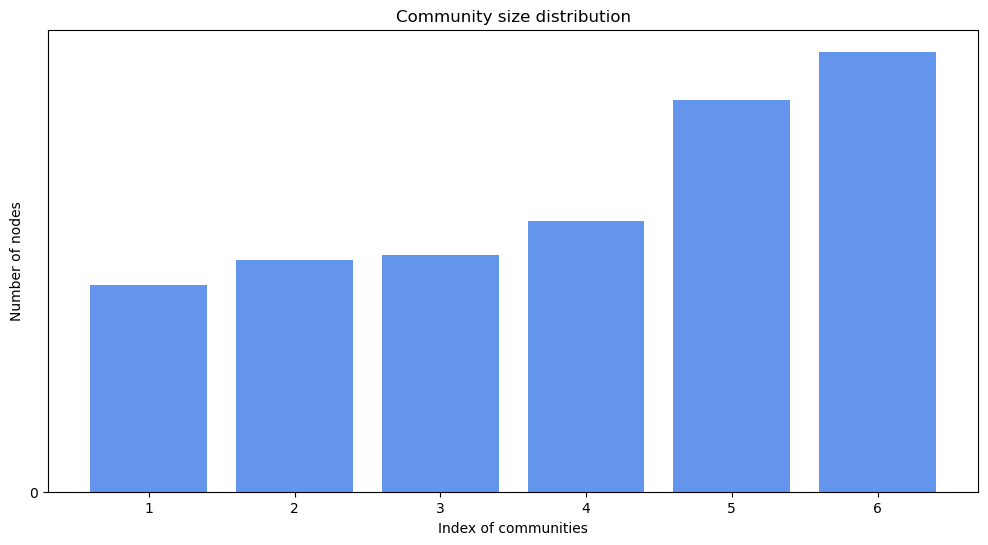

In [17]:
community_size_dist(louvain_partition_articles)
plt.show()

Exponents:
In-degrees: 18.96153192304252 sigma: 7.332764701694212
Out-degrees: 2.0050409787726444 sigma: 0.14818520792607115


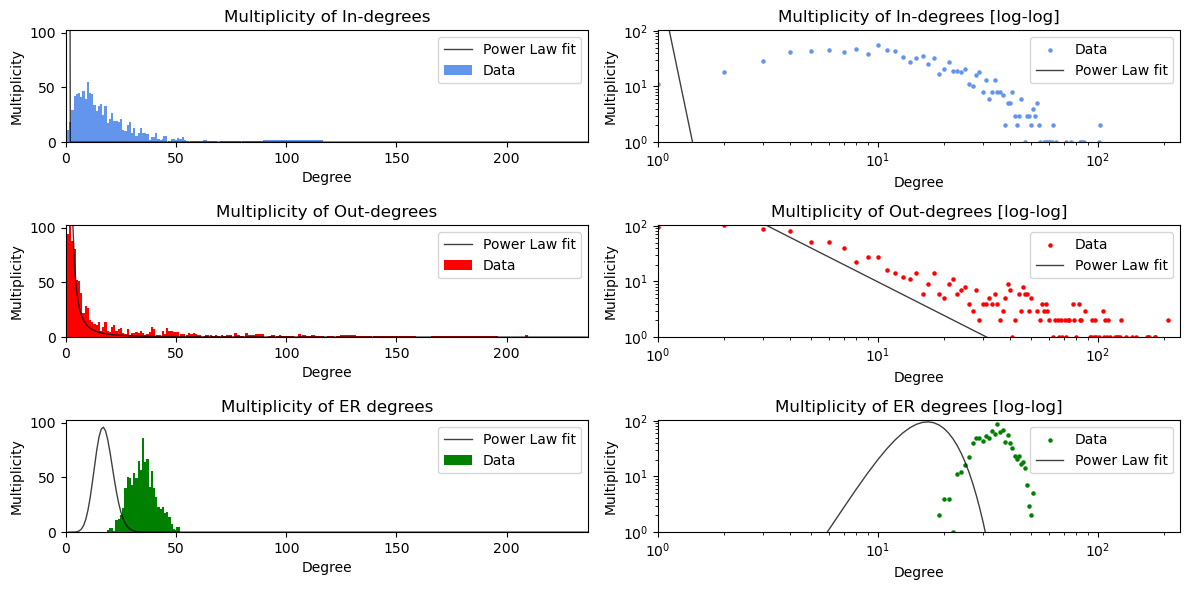

In [18]:
colors = ["cornflowerblue", "red", "green"]
render_degree_distributions(articles_largest_w, colors)
plt.show()

## Edits and editors

We create a graph where the nodes are the talk pages and two nodes are connected by an edge of weight w if exactly w users contributed to both.

In [19]:
edits_u = graph.to_undirected()
users_graph = edits_u.subgraph(type_grouping["user"])
print(f"Number of article pages: {articles_graph.number_of_nodes()}")
print(f"Connections between article pages: {articles_graph.number_of_edges()}")
print(f"Connections between user pages: {users_graph.number_of_edges()}")

def isDifferentClass(graph, u, v):
    ua = graph.nodes[u]["page_class"] == "user" and graph.nodes[v]["page_class"] == "article"
    au = graph.nodes[u]["page_class"] == "article" and graph.nodes[v]["page_class"] == "user"
    return ua or au

print(f"Connections between all nodes: {len(edits_u.edges())}")
print(f"Connections between users and articles: {len([(u,v) for (u, v) in edits_u.edges() if isDifferentClass(edits_u, u, v)])}")

Number of article pages: 1000
Connections between article pages: 17311
Connections between user pages: 0
Connections between all nodes: 174770
Connections between users and articles: 159057


In [20]:
def add_weighted_edges(graph, source, node_type, frontier_type):
    for node in list(graph.nodes):
        related = {}
        frontier = set(n for n in source.neighbors(node) if source.nodes[n]["page_class"] == frontier_type)
        graph.nodes[node]["articles_no"] = len(frontier)
        for f in frontier:
            neighbor_nodes = list( n for n in source.neighbors(f) if source.nodes[n]["page_class"] == node_type)
            for n in neighbor_nodes:
                if n != node:
                    if n in related:
                        related[n] += 1
                    else:
                        related[n] = 1
        graph.add_weighted_edges_from([(node, r, related[r]) for r in related])

In [21]:
common_editors = nx.Graph()
common_editors.add_nodes_from(articles_graph.nodes)
add_weighted_edges(common_editors, edits_u, "article", "user")

Basic analysis on the resulting graph. Slight change in top 5 nodes by degree is probably due to users that only contributed to one article being filtered out.

In [22]:
print(f"Number of nodes: {common_editors.number_of_nodes()}")
print(f"Number of edges: {common_editors.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(common_editors)}")
common_editors_largest_c, degree_stats = basic_stats_undirected(common_editors, 5)
print(f"Average clustering coefficient: {nx.average_clustering(common_editors)}")
print("Top 5 nodes by overall degree")
degree_stats

Number of nodes: 1000
Number of edges: 242107
Number of connected components: 3
Average clustering coefficient: 0.7083478778854763
Top 5 nodes by overall degree


,Degree
Node,
United States,962
Climate change,944
Jesus,944
Human,931
Atheism,922


In [23]:
editors_view = pd.DataFrame(common_editors.nodes(data="editors_no"), columns=["Node", "Editors"]).set_index("Node")
print(f"Maximum weight on edges: {editors_view.Editors.max()}")
print(f"Average weight on edges: {editors_view.Editors.mean()}")
print(f"Median number of editors: {editors_view.Editors.median()}")
print("Top 5 nodes by overall number of editors")
editors_view.sort_values(["Editors"], ascending=False).head(5)

Maximum weight on edges: nan
Average weight on edges: nan
Median number of editors: nan
Top 5 nodes by overall number of editors


,Editors
Node,
Gambling,None
Bronze,None
Abraham Lincoln,None
Ideology,None
Black Death,None


Least popular articles to edit.

In [23]:
editors_view = pd.DataFrame(common_editors.nodes(data="editors_no"), columns=["Node", "Editors"]).set_index("Node")
editors_view.sort_values(["Editors"], ascending=True).head(5)

,Editors
Node,
HIV/AIDS,0
Injury,1
History of Oceania,1
Late modern period,4
Internal structure of Earth,5


Exponents:
Degrees: 20.270106506215566 sigma: 2.9386636923548974


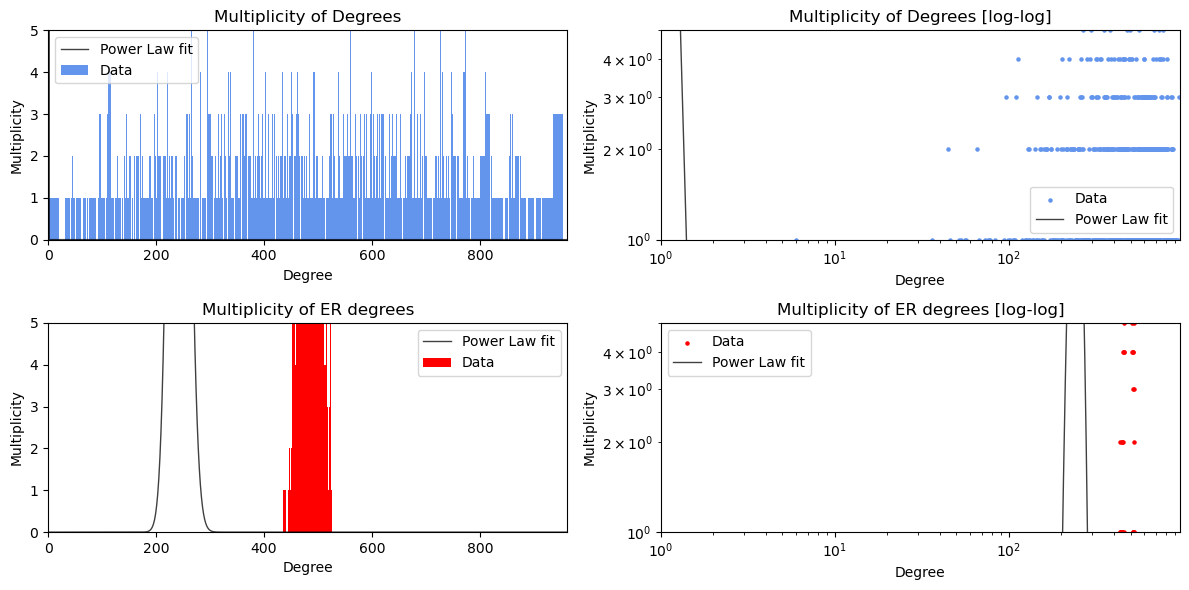

In [24]:
colors = ["cornflowerblue", "red", "green"]
render_degree_distributions(common_editors_largest_c, colors, isDirected=False)
plt.show()

Most connected pairs of talk pages based on number of authors who edited both. Popularity of the two pages might also play a role.

In [25]:
edge_weight_dict = nx.get_edge_attributes(common_editors, "weight")
editors_dict = common_editors.nodes(data="editors_no")
degree_a = [editors_dict[edge[0]] for edge in edge_weight_dict.keys()]
degree_b = [editors_dict[edge[1]] for edge in edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in edge_weight_dict.keys()]
stat_view = pd.DataFrame({"Edge": edges, "Weight": edge_weight_dict.values(), "Editors A": degree_a,
                              "Editors B": degree_b}).set_index("Edge")
print(f"Maximum weight on edges: {stat_view.Weight.max()}")
print(f"Average weight on edges: {stat_view.Weight.mean()}")
print(f"Median number of editors: {stat_view.Weight.median()}")
print("Top 5 nodes by overall number of editors")
most_raw_connected = stat_view.sort_values(["Weight"], ascending=False).head(10)
most_raw_connected

Maximum weight on edges: 221
Average weight on edges: 3.3285695993920044
Median number of editors: 2.0
Top 5 nodes by overall number of editors


,Weight,Editors A,Editors B
Edge,,,
"Jesus, Christianity",221,1879,985
"Jerusalem, Israel",206,637,1612
"Islam, Muhammad",203,1127,1396
"Jesus, United States",178,1879,2221
"Jesus, Muhammad",176,1879,1396
"China, Taiwan",174,842,937
"Jesus, Adolf Hitler",168,1879,1535
"United States, United Kingdom",163,2221,1188
"United States, Israel",147,2221,1612


Now we normalize the weights by the number of editors for each individual article. In this way the highest relative weight is assigned to the article where the biggest percentage of the editor group contributed to both.

In [27]:
for (u, v, data) in common_editors.edges(data=True):
    raw_weight = data["weight"]
    common_editors[u][v]["relative_weight"] = raw_weight * 2 / (editors_dict[u] + editors_dict[v])
nx.write_graphml(common_editors, "weighted_article_connections.graphml")

NetworkXError: GraphML writer does not support <class 'set'> as data values.

In [ ]:
relative_edge_weight_dict = nx.get_edge_attributes(common_editors, "relative_weight")
degree_a = [editors_dict[edge[0]] for edge in relative_edge_weight_dict.keys()]
degree_b = [editors_dict[edge[1]] for edge in relative_edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in relative_edge_weight_dict.keys()]
rel_weight_df = pd.DataFrame({"Edge": edges, "Weight": relative_edge_weight_dict.values(), "Editors A": degree_a,
                              "Editors B": degree_b}).set_index("Edge")
print(f"Average clustering coefficient (relative weights): {nx.average_clustering(common_editors, weight='relative_weight')}")
print(f"Max weight on edges: {rel_weight_df.Weight.max()}")
print(f"Average weight on edges: {rel_weight_df.Weight.mean()}")
print(f"Median weight on edges: {rel_weight_df.Weight.median()}")
rel_weight_df.sort_values(["Weight"], ascending=False).head(10)

In [ ]:
rel_weight_df.loc['Jesus, Adolf Hitler']

In [ ]:
rel_weight_df.sort_values(["Weight"], ascending=False)

In [ ]:
rel_weight_df["Weight"].hist()
plt.show()

Let's see what the common user percent is for the most connected by raw user count.

In [ ]:
rel_weight_df.loc[most_raw_connected.index]

## Community analysis on common editors graph
It seems that a grouping of talk pages based on common editors emerges from our analysis. We will investigate this further with community analysis.

In [ ]:
common_editors.remove_nodes_from([node for node in common_editors.nodes if common_editors.degree(node) < 1])
louvain_partition_raw = nx.community.louvain_communities(common_editors)
print("Weights are common user numbers:")
print( "number of communities found: ", len(louvain_partition_raw))
print("modularity of louvain partitions: ", nx.community.modularity(common_editors, louvain_partition_raw))

for idx, c in enumerate(louvain_partition_raw):
    print(f"{idx + 1}: ", ", ".join(c))

print("---------------------------------")


louvain_partition_rel = nx.community.louvain_communities(common_editors, weight="relative_weight")
print("Weights are relative user numbers:")
print( "number of communities found: ", len(louvain_partition_rel))
print("modularity of louvain partitions: ", nx.community.modularity(common_editors, louvain_partition_rel))

for idx, c in enumerate(louvain_partition_rel):
    print(f"{idx + 1}: ", ", ".join(c))


In [ ]:
titles = ["Community size distribution for raw weights", "Community size distribution for relative weights"]
partitions = [louvain_partition_raw, louvain_partition_rel]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), layout="constrained")
for idx, (titles, partition) in enumerate(zip(titles, partitions)):
    sorted_size_communities = sorted([len(comm) for comm in partition])
    ax[idx].bar([x for x in range(1,len(partition)+1)], sorted_size_communities, color="cornflowerblue")
    ax[idx].set_title(label=titles)
    ax[idx].set_xlabel(xlabel="Index of communities")
    ax[idx].set_ylabel(ylabel="Number of nodes")
    ax[idx].set_xticks([x for x in range (1,len(partition)+1)])
    min_c = sorted_size_communities[0]
    max_c = sorted_size_communities[-1]
    ax[idx].set_ylim((0, max_c + 40))

    rects = ax[idx].patches
    labels = [size for size in sorted_size_communities]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[idx].text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
    
plt.show()

In [ ]:
limit = 100
niche_articles = [node for node in common_editors.nodes if common_editors.nodes[node]["editors_no"] <= limit]
popular_articles = [node for node in common_editors.nodes if common_editors.nodes[node]["editors_no"] > limit]
len(niche_articles), len(popular_articles)

In [ ]:
from itertools import chain

lim = 0.1
rel_connected_edges = rel_weight_df[rel_weight_df.Weight >= lim].index
rel_connected_articles = set(chain.from_iterable([edge.split(", ") for edge in rel_connected_edges]))

removable = set(articles_graph.nodes) - rel_connected_articles
len(removable)

In [ ]:
small_articles_graph = edits_u.copy()
small_articles_graph.remove_nodes_from(removable)
common_articles = nx.Graph()
common_articles.add_nodes_from(users_graph.nodes)
add_weighted_edges(common_articles, small_articles_graph, "user", "article")
edited_articles_dict = common_articles.nodes(data="articles_no")
for (u, v, data) in common_articles.edges(data=True):
    raw_weight = data["weight"]
    common_articles[u][v]["relative_weight"] = raw_weight * 2 / (edited_articles_dict[u] + edited_articles_dict[v])
nx.write_graphml(common_articles, "weighted_user_connections.graphml")

In [ ]:
edge_weight_dict = nx.get_edge_attributes(common_articles, "weight")

degree_a = [edited_articles_dict[edge[0]] for edge in edge_weight_dict.keys()]
degree_b = [edited_articles_dict[edge[1]] for edge in edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in edge_weight_dict.keys()]
stat_view = pd.DataFrame({"Edge": edges, "Weight": edge_weight_dict.values(), "Articles A": degree_a,
                              "Articles B": degree_b}).set_index("Edge")
print(f"Number of nodes: {common_articles.number_of_nodes()}")
print(f"Maximum weight on edges: {stat_view.Weight.max()}")
print(f"Average weight on edges: {stat_view.Weight.mean()}")
print(f"Median number of editors: {stat_view.Weight.median()}")
print("Top 5 connections by overall number of common articles")
# most_raw_connected = stat_view.sort_values(["Weight"], ascending=False).head(10)
# most_raw_connected

In [ ]:
relative_edge_weight_dict = nx.get_edge_attributes(common_articles, "relative_weight")
degree_a = [edited_articles_dict[edge[0]] for edge in relative_edge_weight_dict.keys()]
degree_b = [edited_articles_dict[edge[1]] for edge in relative_edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in relative_edge_weight_dict.keys()]
rel_weight_df = pd.DataFrame({"Edge": edges, "Weight": relative_edge_weight_dict.values(), "Editors A": degree_a,
                              "Editors B": degree_b}).set_index("Edge")

print(f"Average clustering coefficient (relative weights): {nx.average_clustering(common_articles, weight='relative_weight')}")
print(f"Max weight on edges: {rel_weight_df.Weight.max()}")
print(f"Average weight on edges: {rel_weight_df.Weight.mean()}")
print(f"Median weight on edges: {rel_weight_df.Weight.median()}")
rel_weight_df.sort_values(["Weight"], ascending=False).head(10)

In [ ]:
common_articles.remove_nodes_from([node for node in common_articles.nodes if common_articles.degree(node) < 1])
louvain_partition_raw = nx.community.louvain_communities(common_articles)
print("Weights are common user numbers:")
print( "number of communities found: ", len(louvain_partition_raw))
print("modularity of louvain partitions: ", nx.community.modularity(common_articles, louvain_partition_raw))

print("---------------------------------")


louvain_partition_rel = nx.community.louvain_communities(common_articles, weight="relative_weight")
print("Weights are relative user numbers:")
print( "number of communities found: ", len(louvain_partition_rel))
print("modularity of louvain partitions: ", nx.community.modularity(common_articles, louvain_partition_rel))

In [ ]:
titles = ["Community size distribution for raw weights", "Community size distribution for relative weights"]
partitions = [louvain_partition_raw, louvain_partition_rel]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), layout="constrained")
for idx, (titles, partition) in enumerate(zip(titles, partitions)):
    sorted_size_communities = sorted([len(comm) for comm in partition])
    ax[idx].bar([x for x in range(1,len(partition)+1)], sorted_size_communities, color="cornflowerblue")
    ax[idx].set_title(label=titles)
    ax[idx].set_xlabel(xlabel="Index of communities")
    ax[idx].set_ylabel(ylabel="Number of nodes")
    ax[idx].set_xticks([x for x in range (1,len(partition)+1)])
    min_c = sorted_size_communities[0]
    max_c = sorted_size_communities[-1]
    ax[idx].set_ylim((0, max_c + 40))

    rects = ax[idx].patches
    labels = [size for size in sorted_size_communities]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[idx].text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
    
plt.show()
